
# <center>Lectura de números escritos a mano Dataset MNIST</center>
# <center>con distintos algoritmos de clasificacion</center>

<a name="id8"></a>
**Índice**   
1. [KNN](#id1)
2. [Arbol de decisión](#id2)
3. [SVM](#id3)
4. [Regresión Logística](#id4)
5. [Random Forest](#id5)
6. [XGBoost](#id6)
7. [RESUMEN FINAL](#id7)

Carguemos las librerías necesarias

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBRegressor, XGBClassifier

from sklearn.model_selection import train_test_split,ParameterGrid
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


### Acerca del set de datos

MNIST dataset is derived from the NIST dataset. It contains 60000 training and 10000 testing images of size 28x28 in grayscale. Digits have been recentered on the raster using the center of mass.

### Cargar Datos a partir de un archivo gz descomprimido en la misma carpeta

In [2]:
import idx2numpy

# Ojo no reconoce el caracter ~y he tenido que dejar los ficheros en la misma carpeta que el ipynb
file = "train-images-idx3-ubyte"
xTrain = idx2numpy.convert_from_file(file)
file = "t10k-images-idx3-ubyte"
xTest = idx2numpy.convert_from_file(file)
file = "train-labels-idx1-ubyte"
yTrain = idx2numpy.convert_from_file(file)
file = "t10k-labels-idx1-ubyte"
yTest = idx2numpy.convert_from_file(file)


In [3]:
xTrain = xTrain / 255.
xTest  = xTest  / 255.

digitClasses = np.array([str(d) for d in range(10)])

xTrain.shape, xTest.shape, yTrain.shape, yTest.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [4]:
#el array 2D lo paso a vector 1d como entrada al algoritmo
xTrain_flat = np.reshape(xTrain, (60000,784))
xTest_flat = np.reshape(xTest, (10000,784))

# Visualización de Datos y Análisis 



Puedes explorar fácilmente tus datos utilizando técnicas de visualización:

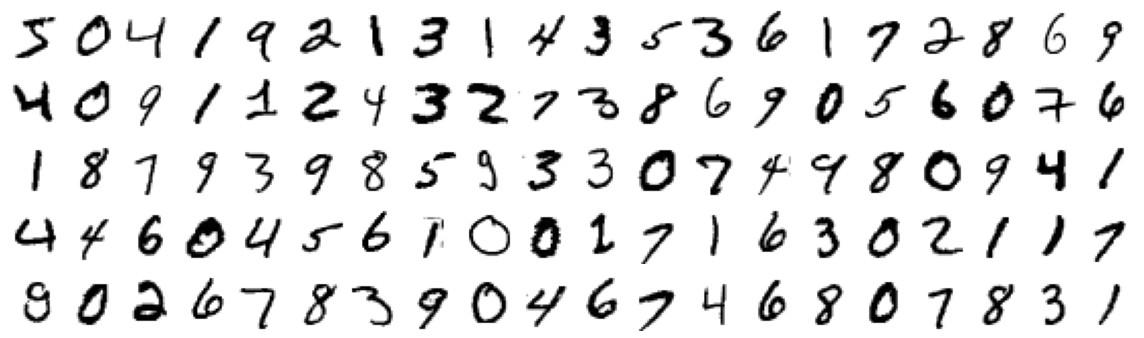

In [5]:
fig, axes = plt.subplots(5, 20, figsize=(16, 5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(xTrain[i], cmap='gray_r')
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)

## Normalizacion y Train Test Split  
Ya está hecho arriba

# Clasificación 

<a name="id1"></a>
## K-vecinos más cercano (K-NN)

### Directamente optimizo hiperparámetros

In [6]:
Ks = 7
mean_acc = np.zeros((Ks-3))
std_acc = np.zeros((Ks-3))

for n in range(3,Ks):
    #Entrenar el Modelo y Predecir  
    neigh = KNeighborsClassifier(n_neighbors = n)
    neigh.fit(xTrain_flat, yTrain)
    yhat = neigh.predict(xTest_flat)
    # Guardo la precisión
    mean_acc[n-3] = accuracy_score(yTest, yhat) 
    std_acc[n-3]=np.std(yhat==yTest)/np.sqrt(yhat.shape[0])


#### Dibujo de la certeza del modelo para diferentes números de vecinos

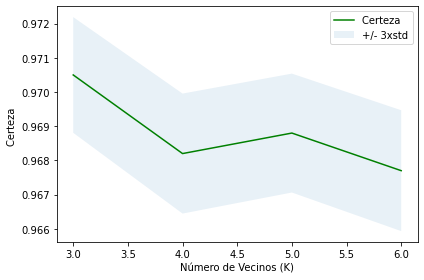

In [7]:
plt.plot(range(3,Ks),mean_acc,'g')
plt.fill_between(range(3,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Certeza ', '+/- 3xstd'))
plt.ylabel('Certeza ')
plt.xlabel('Número de Vecinos (K)')
plt.tight_layout()
plt.show()

In [8]:
print( "La mejor aproximación de certeza fue con ", mean_acc.max(), "con k=", mean_acc.argmax()+3)

La mejor aproximación de certeza fue con  0.9705 con k= 3


### Creo, entreno y evalúo el modelo con los mejores hiperparámetros

In [9]:
#Me quedo con el modelo mejor y lo entreno con Xtrain e Ytrain
knn_model = KNeighborsClassifier(n_neighbors = mean_acc.argmax()+3)
knn_model.fit(xTrain_flat, yTrain)

#Hago predicción con X test y lo comparo con y test
ypred = knn_model.predict(xTrain_flat)
yhat = knn_model.predict(xTest_flat)
  
#print('Parametros del mejor arbol: ',resultados.at[0,'criterion'],resultados.at[0,'max_depth'],resultados.at[0,'max_features'])    
knn_acc_train = accuracy_score(yTrain, ypred)
knn_acc_test = accuracy_score(yTest, yhat)

print("Precisión de entrenamiento: ", knn_acc_train)
print("Precisión de test: ", knn_acc_test)
knn_model


Precisión de entrenamiento:  0.9867166666666667
Precisión de test:  0.9705


KNeighborsClassifier(n_neighbors=3)

In [10]:
print(confusion_matrix(yTest, yhat, labels=sorted(np.unique(yTrain))))
print (classification_report(yTest, yhat))

[[ 974    1    1    0    0    1    2    1    0    0]
 [   0 1133    2    0    0    0    0    0    0    0]
 [  10    9  996    2    0    0    0   13    2    0]
 [   0    2    4  976    1   13    1    7    3    3]
 [   1    6    0    0  950    0    4    2    0   19]
 [   6    1    0   11    2  859    5    1    3    4]
 [   5    3    0    0    3    3  944    0    0    0]
 [   0   21    5    0    1    0    0  991    0   10]
 [   8    2    4   16    8   11    3    4  914    4]
 [   4    5    2    8    9    2    1    8    2  968]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.96      1.00      0.98      1135
           2       0.98      0.97      0.97      1032
           3       0.96      0.97      0.96      1010
           4       0.98      0.97      0.97       982
           5       0.97      0.96      0.96       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96   

<a name="id2"></a>
## Arbol de decisión

### Directamente optimizo hiperparámetros

In [11]:
## Optimizo los hiperparámetros
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'max_features': [10, 50, 100],
                 'max_depth'   : [10, 50, 100],
                 'criterion'   : [ 'entropy','gini']
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'accuracy': []}

for params in param_grid:
    
    modelo = DecisionTreeClassifier(        
                random_state = 123,
                ** params
             )
    
    modelo.fit(xTrain_flat, yTrain)
    yhat= modelo.predict(xTest_flat)
    
    resultados['params'].append(params)
    resultados['accuracy'].append(accuracy_score(yTest,yhat))
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(7)

Modelo: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 10} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 50} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 100} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 50, 'max_features': 10} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 50, 'max_features': 50} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 50, 'max_features': 100} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 100, 'max_features': 10} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 100, 'max_features': 50} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 100, 'max_features': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 10} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 50, 'max_features': 10} ✓
Modelo: {'criterion': 'gini', 'max_depth': 50, 'max_features': 50} ✓


,accuracy,criterion,max_depth,max_features
5,0.8729,entropy,50,100
8,0.8729,entropy,100,100
17,0.8680,gini,100,100
14,0.8680,gini,50,100
4,0.8630,entropy,50,50
7,0.8630,entropy,100,50
16,0.8602,gini,100,50


### Creo, entreno y evalúo el modelo con los mejores hiperparámetros

In [12]:
#Creo el modelo y lo entreno con X e Y train
resultados = resultados.reset_index(drop=True)
dt_model = DecisionTreeClassifier(criterion=resultados.at[0,'criterion'],
                                  max_depth = resultados.at[0,'max_depth'],
                                  max_features = resultados.at[0,'max_features'])
dt_model.fit(xTrain_flat,yTrain)

#Hago predicción con X test y lo comparo con y test
ypred = dt_model.predict(xTrain_flat)
yhat2 = dt_model.predict(xTest_flat)
 
#print('Parametros del mejor arbol: ',resultados.at[0,'criterion'],resultados.at[0,'max_depth'],resultados.at[0,'max_features'])    
dt_acc_train = accuracy_score(yTrain, ypred)
dt_acc_test = accuracy_score(yTest, yhat2)

print("Precisión de entrenamiento: ", dt_acc_train)
print("Precisión de test: ", dt_acc_test)
dt_model


Precisión de entrenamiento:  1.0
Precisión de test:  0.8732


DecisionTreeClassifier(criterion='entropy', max_depth=50, max_features=100)

In [13]:
print(confusion_matrix(yTest, yhat2, labels=sorted(np.unique(yTrain))))
print (classification_report(yTest, yhat2))

[[ 903    1   11    6    5   12   24    4    6    8]
 [   1 1095    4    7    1    6    7    6    6    2]
 [  16    7  888   33   10    7   14   21   32    4]
 [   8    2   27  855    7   47    7   15   24   18]
 [   5    5   17    5  843   10   10   11   21   55]
 [  15    6    7   35   10  749   15   11   25   19]
 [  14    8   13    8   17   21  862    3    9    3]
 [   3    7   28   20   12    3    1  921   13   20]
 [  17    3   34   32   19   40   17   15  769   28]
 [   8    7    9   23   37   13    3   33   29  847]]
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       980
           1       0.96      0.96      0.96      1135
           2       0.86      0.86      0.86      1032
           3       0.83      0.85      0.84      1010
           4       0.88      0.86      0.87       982
           5       0.82      0.84      0.83       892
           6       0.90      0.90      0.90       958
           7       0.89      0.90   

In [14]:
importancia_predictores = pd.DataFrame(
                            {'predictor': range(784),
                             'importancia': dt_model.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
155,155,0.091471
656,656,0.055581
401,401,0.052918
488,488,0.044730
541,541,0.032340
...,...,...
253,253,0.000000
252,252,0.000000
251,251,0.000000
249,249,0.000000


In [15]:
# #Preparo las etiquetas del arbol
# a = np.asarray(range(784))
# featureNames = a.astype('str')
# targetNames = sorted(np.unique(yTrain).astype('str'))

# #Esto Genera bien el fichero .dot
# # arbol_dot = tree.export_graphviz(drugTree, out_file='drugtree.dot',
# #                                  feature_names=featureNames, class_names=targetNames ,
# #                                  filled=True, special_characters=True)  

# #Esto pinta bien el arbol, hay que poner antes el tamaño de la figura, sino lo hace muy pequeño
# plt.figure(figsize=(10, 10))
# plot_tree(dt_model, feature_names=featureNames, class_names=targetNames, filled=True, rounded=True,)
# plt.show()

<a name="id3"></a>
## SVM Support Vector Machines 

### Directamente optimizo hiperparámetros

In [16]:
# Itero con 3 de los 4 posibles kernel de SVM para ver cual es el mejor
kernel_params=['linear','poly','rbf']  #,'sigmoid'] da un 77.6%
acc_svm = pd.DataFrame(index=kernel_params)

for i in kernel_params:
    svm_model = svm.SVC(kernel=i)
    svm_model.fit(xTrain_flat, yTrain)
    yhat3 = svm_model.predict(xTest_flat)
    acc_svm.at[i,'accuracy'] = accuracy_score(yTest, yhat3)

# Extraigo el mejor
mejor_kernel = acc_svm[acc_svm['accuracy']==acc_svm['accuracy'].max()].index
mejor_kernel = np.array(mejor_kernel).astype('str')
print('El mejor kernel es ', mejor_kernel[0],'con una precisión de: ',acc_svm['accuracy'].max())
acc_svm  

El mejor kernel es  rbf con una precisión de:  0.9792


,accuracy
linear,0.9404
poly,0.9771
rbf,0.9792


### Creo, entreno y evalúo el modelo con los mejores hiperparámetros

In [17]:
# Construyo el modelo final con ese Kernel
svm_model = svm.SVC(kernel=mejor_kernel[0])
svm_model.fit(xTrain_flat,yTrain)


#Hago predicción con X train y test
ypred = svm_model.predict(xTrain_flat)
yhat3 = svm_model.predict(xTest_flat)

svm_acc_train = accuracy_score(yTrain, ypred)
svm_acc_test = accuracy_score(yTest, yhat3)

print("Precisión de entrenamiento: ", svm_acc_train)
print("Precisión de test: ", svm_acc_test)

svm_model

Precisión de entrenamiento:  0.9899166666666667
Precisión de test:  0.9792


SVC()

In [18]:
print(confusion_matrix(yTest, yhat3, labels=sorted(np.unique(yTrain))))
print (classification_report(yTest, yhat3))

[[ 973    0    1    0    0    2    1    1    2    0]
 [   0 1126    3    1    0    1    1    1    2    0]
 [   6    1 1006    2    1    0    2    7    6    1]
 [   0    0    2  995    0    2    0    5    5    1]
 [   0    0    5    0  961    0    3    0    2   11]
 [   2    0    0    9    0  871    4    1    4    1]
 [   6    2    0    0    2    3  944    0    1    0]
 [   0    6   11    1    1    0    0  996    2   11]
 [   3    0    2    6    3    2    2    3  950    3]
 [   3    4    1    7   10    2    1    7    4  970]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.97   

<a name="id4"></a>
## Regresión Logística

### Directamente optimizo hiperparámetros

In [19]:
# Itero con los 5 posibles Solver de Reg Logística para ver cual es el mejor
solver_params=['lbfgs','liblinear','newton-cg']  #,'sag','saga'] dan lo mismo que newton
acc_lr = pd.DataFrame(index=solver_params)

for i in solver_params:
    lr_model = LogisticRegression(C=0.01, solver=i)
    lr_model.fit(xTrain_flat, yTrain)
    y_hat7 = lr_model.predict(xTest_flat)
    acc_lr.at[i,'accuracy'] = accuracy_score(yTest, y_hat7)

# Extraigo el mejor
mejor_solver = acc_lr[acc_lr['accuracy']==acc_lr['accuracy'].max()].index
mejor_solver = np.array(mejor_solver).astype('str')
print('El mejor kernel es ', mejor_solver[0],'con una precisión de: ',acc_lr['accuracy'].max())
acc_lr  


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


El mejor kernel es  lbfgs con una precisión de:  0.9189


,accuracy
lbfgs,0.9189
liblinear,0.9123
newton-cg,0.9187


### Creo, entreno y evalúo el modelo con los mejores hiperparámetros

In [20]:
# Construyo el modelo final con ese Solver
lr_model = LogisticRegression(C=0.01,solver=mejor_solver[0])
lr_model.fit(xTrain_flat, yTrain)

#Hago predicción con X train y test
ypred = lr_model.predict(xTrain_flat)
yhat4 = lr_model.predict(xTest_flat)

lr_acc_train = accuracy_score(yTrain, ypred)
lr_acc_test = accuracy_score(yTest, yhat4)

print("Precisión de entrenamiento: ", lr_acc_train)
print("Precisión de test: ", lr_acc_test)

lr_model

/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Precisión de entrenamiento:  0.9185333333333333
Precisión de test:  0.9189


LogisticRegression(C=0.01)

In [21]:
print(confusion_matrix(yTest, yhat4, labels=sorted(np.unique(yTrain))))
print (classification_report(yTest, yhat4))

[[ 960    0    2    1    0    5    9    1    2    0]
 [   0 1109    2    2    0    2    4    2   14    0]
 [   9    9  911   16   13    2   15   13   36    8]
 [   3    1   22  915    0   25    2   14   16   12]
 [   1    4    2    1  917    1   11    2    9   34]
 [  10    3    2   36    8  778   16    6   27    6]
 [  12    3    4    1   10   14  908    3    3    0]
 [   2   12   22    9    6    0    0  940    2   35]
 [   7   10    7   23    9   32   11   11  853   11]
 [  11    8    2   11   36    8    0   27    8  898]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.88      0.91      1032
           3       0.90      0.91      0.90      1010
           4       0.92      0.93      0.93       982
           5       0.90      0.87      0.88       892
           6       0.93      0.95      0.94       958
           7       0.92      0.91   

<a name="id5"></a>
## Random Forest

### Directamente optimizo hiperparámetros

In [22]:

# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'max_features': [10, 50, 100],
                 'max_depth'   : [10, 50],
                 'criterion'   : ['gini', 'entropy']
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:
    
    modelo = RandomForestClassifier(
                n_estimators= 100,        
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(xTrain_flat, yTrain)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados = resultados.reset_index(drop=True)
resultados.head(4)

Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 10} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 50, 'max_features': 10} ✓
Modelo: {'criterion': 'gini', 'max_depth': 50, 'max_features': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': 50, 'max_features': 100} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 10} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 50} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 100} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 50, 'max_features': 10} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 50, 'max_features': 50} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 50, 'max_features': 100} ✓


,oob_accuracy,criterion,max_depth,max_features
0,0.967033,entropy,50,100
1,0.966567,gini,50,100
2,0.965933,entropy,50,50
3,0.965733,gini,50,50


### Creo, entreno y evalúo el modelo con los mejores hiperparámetros

In [23]:
#Creo el modelo y lo entreno con X e Y train
rf_model = RandomForestClassifier(criterion=resultados.at[0,'criterion'],
                                  max_depth = resultados.at[0,'max_depth'],
                                  max_features = resultados.at[0,'max_features'])
rf_model.fit(xTrain_flat, yTrain)

#Hago predicción con Xtrain y Xtest
ypred = rf_model.predict(xTrain_flat)
yhat5 = rf_model.predict(xTest_flat)

# Saco la precisión del modelo con set de entrenamiento y con conjunto de test
rf_acc_train = accuracy_score(yTrain, ypred)
rf_acc_test = accuracy_score(yTest, yhat5)

print("Precisión de entrenamiento: ", rf_acc_train)
print("Precisión de test: ", rf_acc_test)

rf_model

Precisión de entrenamiento:  1.0
Precisión de test:  0.9688


RandomForestClassifier(criterion='entropy', max_depth=50, max_features=100)

In [24]:
importancia_predictores = pd.DataFrame(
                            {'predictor': range(784),
                             'importancia': rf_model.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
378,378,0.020932
569,569,0.019558
461,461,0.018378
568,568,0.016987
155,155,0.016176
...,...,...
280,280,0.000000
308,308,0.000000
335,335,0.000000
336,336,0.000000


In [25]:
print(confusion_matrix(yTest, yhat5, labels=sorted(np.unique(yTrain))))
print (classification_report(yTest, yhat5))

[[ 972    0    1    0    0    2    1    1    2    1]
 [   0 1121    2    4    0    2    3    1    2    0]
 [   6    1 1000    2    3    0    6    8    6    0]
 [   2    0   14  966    0    9    0    9    7    3]
 [   1    0    0    0  956    0    6    1    4   14]
 [   3    1    0   14    3  855    6    2    4    4]
 [   7    3    2    0    5    5  932    0    4    0]
 [   1    4   19    2    2    0    0  990    5    5]
 [   3    0    7    4    3    5    7    3  933    9]
 [   6    5    2    9   10    5    1    3    5  963]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.97      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.96      0.96       892
           6       0.97      0.97      0.97       958
           7       0.97      0.96   

<a name="id6"></a>
## XGBoost

### Directamente optimizo hiperparámetros

/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-merror:0.30690	validation_0-mlogloss:2.07816	validation_1-merror:0.30300	validation_1-mlogloss:2.07673
[1]	validation_0-merror:0.23570	validation_0-mlogloss:1.90607	validation_1-merror:0.23110	validation_1-mlogloss:1.90545
[2]	validation_0-merror:0.22248	validation_0-mlogloss:1.77064	validation_1-merror:0.21730	validation_1-mlogloss:1.76997
[3]	validation_0-merror:0.20405	validation_0-mlogloss:1.65172	validation_1-merror:0.19910	validation_1-mlogloss:1.65108
[4]	validation_0-merror:0.19208	validation_0-mlogloss:1.55033	validation_1-merror:0.18860	validation_1-mlogloss:1.54841
[5]	validation_0-merror:0.18457	validation_0-mlogloss:1.46236	validation_1-merror:0.18050	validation_1-mlogloss:1.46077
[6]	validation_0-merror:0.17770	validation_0-mlogloss:1.38020	validation_1-merror:0.17450	validation_1-mlogloss:1.37890
[7]	validation_0-merror:0.17150	validation_0-mlogloss:1.30746	validation_1-merror:0.16690	validation_1-mlogloss:1.30588
[8]	validation_0-merror:0.16762	validati

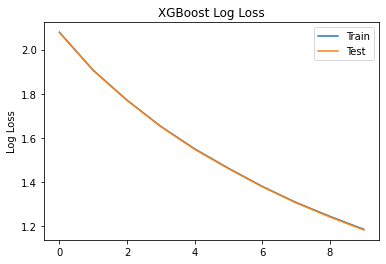

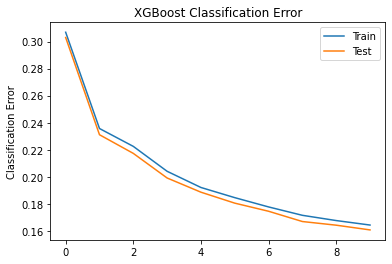

Modelo: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-merror:0.17212	validation_0-mlogloss:1.98783	validation_1-merror:0.17410	validation_1-mlogloss:1.98893
[1]	validation_0-merror:0.13867	validation_0-mlogloss:1.76554	validation_1-merror:0.14660	validation_1-mlogloss:1.76837
[2]	validation_0-merror:0.12173	validation_0-mlogloss:1.59419	validation_1-merror:0.12890	validation_1-mlogloss:1.59873
[3]	validation_0-merror:0.11053	validation_0-mlogloss:1.45319	validation_1-merror:0.11850	validation_1-mlogloss:1.45895
[4]	validation_0-merror:0.10535	validation_0-mlogloss:1.33260	validation_1-merror:0.11330	validation_1-mlogloss:1.33942
[5]	validation_0-merror:0.10197	validation_0-mlogloss:1.23125	validation_1-merror:0.10960	validation_1-mlogloss:1.23888
[6]	validation_0-merror:0.09747	validation_0-mlogloss:1.14162	validation_1-merror:0.10450	validation_1-mlogloss:1.14993
[7]	validation_0-merror:0.09452	validation_0-mlogloss:1.06146	validation_1-merror:0.10040	validation_1-mlogloss:1.07090
[8]	validation_0-merror:0.09125	validati

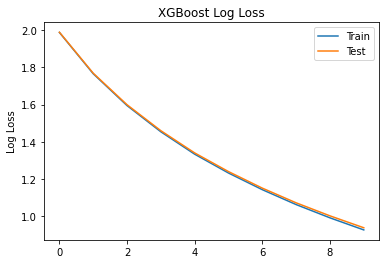

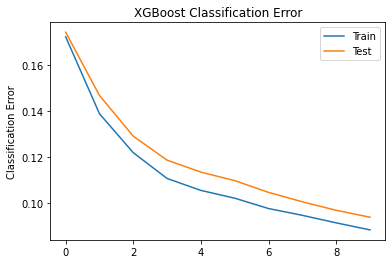

Modelo: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 10} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-merror:0.30690	validation_0-mlogloss:1.38380	validation_1-merror:0.30300	validation_1-mlogloss:1.37625
[1]	validation_0-merror:0.22037	validation_0-mlogloss:1.06617	validation_1-merror:0.22100	validation_1-mlogloss:1.06139
[2]	validation_0-merror:0.18387	validation_0-mlogloss:0.87367	validation_1-merror:0.18400	validation_1-mlogloss:0.86782
[3]	validation_0-merror:0.16127	validation_0-mlogloss:0.74031	validation_1-merror:0.16220	validation_1-mlogloss:0.73640
[4]	validation_0-merror:0.14573	validation_0-mlogloss:0.64864	validation_1-merror:0.14580	validation_1-mlogloss:0.64487
[5]	validation_0-merror:0.13293	validation_0-mlogloss:0.57307	validation_1-merror:0.13550	validation_1-mlogloss:0.57268
[6]	validation_0-merror:0.12383	validation_0-mlogloss:0.51752	validation_1-merror:0.12540	validation_1-mlogloss:0.51966
[7]	validation_0-merror:0.11495	validation_0-mlogloss:0.46922	validation_1-merror:0.11720	validation_1-mlogloss:0.47214
[8]	validation_0-merror:0.10655	validati

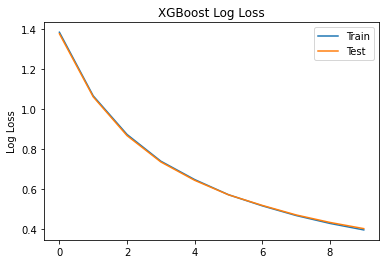

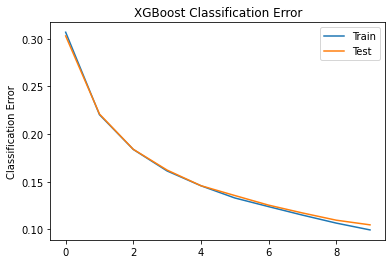

Modelo: {'gamma': 0.1, 'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 10} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-merror:0.17212	validation_0-mlogloss:1.04399	validation_1-merror:0.17410	validation_1-mlogloss:1.04911
[1]	validation_0-merror:0.12005	validation_0-mlogloss:0.75388	validation_1-merror:0.12580	validation_1-mlogloss:0.76773
[2]	validation_0-merror:0.09663	validation_0-mlogloss:0.57311	validation_1-merror:0.10370	validation_1-mlogloss:0.59399
[3]	validation_0-merror:0.08297	validation_0-mlogloss:0.45526	validation_1-merror:0.09300	validation_1-mlogloss:0.48221
[4]	validation_0-merror:0.07210	validation_0-mlogloss:0.37244	validation_1-merror:0.08500	validation_1-mlogloss:0.40511
[5]	validation_0-merror:0.06357	validation_0-mlogloss:0.31194	validation_1-merror:0.07990	validation_1-mlogloss:0.34818
[6]	validation_0-merror:0.05603	validation_0-mlogloss:0.26386	validation_1-merror:0.07350	validation_1-mlogloss:0.30387
[7]	validation_0-merror:0.05043	validation_0-mlogloss:0.23052	validation_1-merror:0.06840	validation_1-mlogloss:0.27253
[8]	validation_0-merror:0.04488	validati

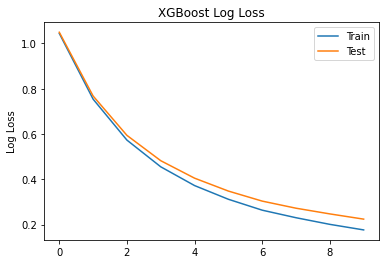

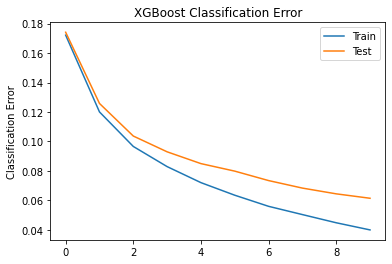

Modelo: {'gamma': 0.1, 'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 10} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-merror:0.30690	validation_0-mlogloss:1.07762	validation_1-merror:0.30300	validation_1-mlogloss:1.06148
[1]	validation_0-merror:0.21020	validation_0-mlogloss:0.74546	validation_1-merror:0.21330	validation_1-mlogloss:0.74160
[2]	validation_0-merror:0.17037	validation_0-mlogloss:0.58091	validation_1-merror:0.17530	validation_1-mlogloss:0.58277
[3]	validation_0-merror:0.14113	validation_0-mlogloss:0.48293	validation_1-merror:0.14690	validation_1-mlogloss:0.49247
[4]	validation_0-merror:0.12160	validation_0-mlogloss:0.41448	validation_1-merror:0.12680	validation_1-mlogloss:0.43049
[5]	validation_0-merror:0.11027	validation_0-mlogloss:0.36706	validation_1-merror:0.11610	validation_1-mlogloss:0.38747
[6]	validation_0-merror:0.09748	validation_0-mlogloss:0.32456	validation_1-merror:0.10390	validation_1-mlogloss:0.34775
[7]	validation_0-merror:0.08942	validation_0-mlogloss:0.29357	validation_1-merror:0.09850	validation_1-mlogloss:0.32014
[8]	validation_0-merror:0.08153	validati

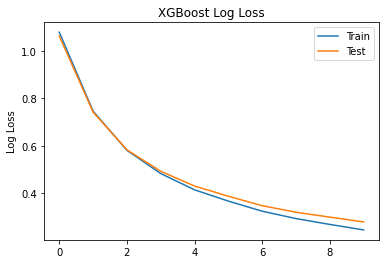

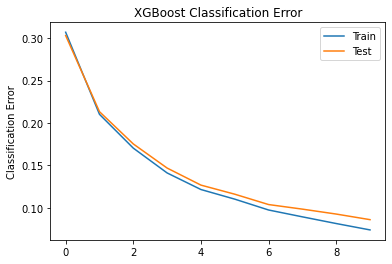

Modelo: {'gamma': 0.1, 'learning_rate': 1, 'max_depth': 3, 'n_estimators': 10} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-merror:0.17212	validation_0-mlogloss:0.68256	validation_1-merror:0.17410	validation_1-mlogloss:0.69230
[1]	validation_0-merror:0.11035	validation_0-mlogloss:0.42349	validation_1-merror:0.12560	validation_1-mlogloss:0.46347
[2]	validation_0-merror:0.08323	validation_0-mlogloss:0.30191	validation_1-merror:0.10260	validation_1-mlogloss:0.35631
[3]	validation_0-merror:0.06665	validation_0-mlogloss:0.23319	validation_1-merror:0.09090	validation_1-mlogloss:0.29913
[4]	validation_0-merror:0.05253	validation_0-mlogloss:0.18157	validation_1-merror:0.07870	validation_1-mlogloss:0.25861
[5]	validation_0-merror:0.04178	validation_0-mlogloss:0.14706	validation_1-merror:0.07160	validation_1-mlogloss:0.23112
[6]	validation_0-merror:0.03448	validation_0-mlogloss:0.12190	validation_1-merror:0.06610	validation_1-mlogloss:0.21328
[7]	validation_0-merror:0.02847	validation_0-mlogloss:0.10226	validation_1-merror:0.06240	validation_1-mlogloss:0.19825
[8]	validation_0-merror:0.02275	validati

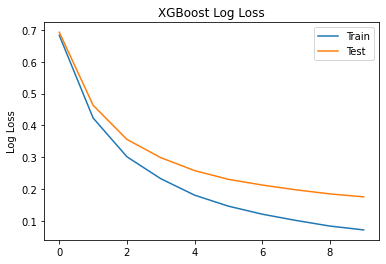

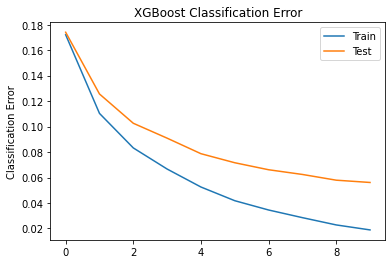

Modelo: {'gamma': 0.1, 'learning_rate': 1, 'max_depth': 5, 'n_estimators': 10} ✓


,accuracy,gamma,learning_rate,max_depth,n_estimators
0,0.9439,0.1,1.0,5.0,10.0
1,0.9385,0.1,0.5,5.0,10.0
2,0.9139,0.1,1.0,3.0,10.0
3,0.9063,0.1,0.1,5.0,10.0
4,0.8953,0.1,0.5,3.0,10.0
5,0.8393,0.1,0.1,3.0,10.0


In [26]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [10],
                 'learning_rate': [0.1, 0.5, 1],
                 'max_depth'   : [3, 5],
                 'gamma' : [0.1]
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'accuracy': []}

for params in param_grid:
    
    xgb_model = XGBClassifier(
                ** params
             )

    eval_set = eval_set = [(xTrain_flat, yTrain), (xTest_flat, yTest)]
    xgb_model.fit(xTrain_flat, yTrain, eval_metric=["merror", "mlogloss"], eval_set=eval_set, verbose=True)
    
    # retrieve performance metrics
    results = xgb_model.evals_result()
    epochs = len(results['validation_0']['merror'])
    x_axis = range(0, epochs)
    # plot log loss
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
    ax.legend()
    plt.ylabel('Log Loss')
    plt.title('XGBoost Log Loss')
    plt.show()
    # plot classification error
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['merror'], label='Train')
    ax.plot(x_axis, results['validation_1']['merror'], label='Test')
    ax.legend()
    plt.ylabel('Classification Error')
    plt.title('XGBoost Classification Error')
    plt.show()

    yhat6= xgb_model.predict(xTest_flat)
    
    resultados['params'].append(params)
    resultados['accuracy'].append(accuracy_score(yTest,yhat6))
    print(f"Modelo: {params} \u2713")

    
    
# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados = resultados.reset_index(drop=True)
resultados.head(7)

### Creo, entreno y evalúo el modelo con los mejores hiperparámetros

/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-merror:0.30690	validation_0-mlogloss:1.38380	validation_1-merror:0.30300	validation_1-mlogloss:1.37625
[1]	validation_0-merror:0.22037	validation_0-mlogloss:1.06617	validation_1-merror:0.22100	validation_1-mlogloss:1.06139
[2]	validation_0-merror:0.18387	validation_0-mlogloss:0.87367	validation_1-merror:0.18400	validation_1-mlogloss:0.86782
[3]	validation_0-merror:0.16127	validation_0-mlogloss:0.74031	validation_1-merror:0.16220	validation_1-mlogloss:0.73640
[4]	validation_0-merror:0.14573	validation_0-mlogloss:0.64864	validation_1-merror:0.14580	validation_1-mlogloss:0.64487
[5]	validation_0-merror:0.13293	validation_0-mlogloss:0.57307	validation_1-merror:0.13550	validation_1-mlogloss:0.57268
[6]	validation_0-merror:0.12383	validation_0-mlogloss:0.51752	validation_1-merror:0.12540	validation_1-mlogloss:0.51966
[7]	validation_0-merror:0.11495	validation_0-mlogloss:0.46922	validation_1-merror:0.11720	validation_1-mlogloss:0.47214
[8]	validation_0-merror:0.10655	validati

[68]	validation_0-merror:0.01428	validation_0-mlogloss:0.06578	validation_1-merror:0.03720	validation_1-mlogloss:0.12082
[69]	validation_0-merror:0.01362	validation_0-mlogloss:0.06448	validation_1-merror:0.03680	validation_1-mlogloss:0.11983
[70]	validation_0-merror:0.01330	validation_0-mlogloss:0.06332	validation_1-merror:0.03660	validation_1-mlogloss:0.11911
[71]	validation_0-merror:0.01298	validation_0-mlogloss:0.06201	validation_1-merror:0.03640	validation_1-mlogloss:0.11849
[72]	validation_0-merror:0.01270	validation_0-mlogloss:0.06085	validation_1-merror:0.03600	validation_1-mlogloss:0.11763
[73]	validation_0-merror:0.01237	validation_0-mlogloss:0.05947	validation_1-merror:0.03590	validation_1-mlogloss:0.11629
[74]	validation_0-merror:0.01190	validation_0-mlogloss:0.05831	validation_1-merror:0.03590	validation_1-mlogloss:0.11594
[75]	validation_0-merror:0.01152	validation_0-mlogloss:0.05729	validation_1-merror:0.03560	validation_1-mlogloss:0.11549
[76]	validation_0-merror:0.01122

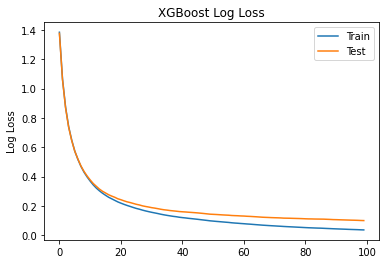

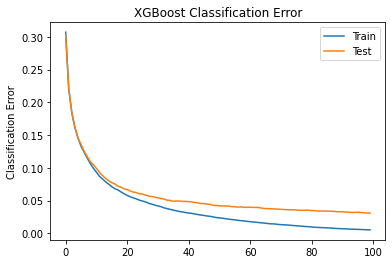

Precisión del Arbol de entrenamiento:  0.9948
Precisión del Arbol de test:  0.9691


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [27]:
#Creo el modelo con mejores parámetros y lo entreno con X e Y train
xgb_model = XGBClassifier(n_estimators = 100,
                          learning_rate = 0.5,
                          max_depth = 3,
                          gamma = 0.1)

xgb_model.fit(xTrain_flat, yTrain, 
              eval_metric=["merror", "mlogloss"], eval_set=eval_set, 
              early_stopping_rounds=5, verbose=True)

# retrieve performance metrics
results = xgb_model.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

ypred = xgb_model.predict(xTrain_flat)
yhat6 = xgb_model.predict(xTest_flat)

xgb_acc_train = accuracy_score(yTrain, ypred)
xgb_acc_test = accuracy_score(yTest, yhat6)

print("Precisión del Arbol de entrenamiento: ", xgb_acc_train)
print("Precisión del Arbol de test: ", xgb_acc_test)
xgb_model

In [28]:
importancia_predictores = pd.DataFrame(
                            {'predictor': range(784),
                             'importancia': xgb_model.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
67,67,0.064998
70,70,0.055118
220,220,0.045512
277,277,0.031514
101,101,0.028053
...,...,...
252,252,0.000000
251,251,0.000000
250,250,0.000000
227,227,0.000000


In [29]:
print(confusion_matrix(yTest, yhat6, labels=sorted(np.unique(yTrain))))
print (classification_report(yTest, yhat6))

[[ 968    0    0    0    0    4    3    1    4    0]
 [   0 1123    3    2    1    0    2    0    4    0]
 [   3    0  994    7    7    0    1    6   10    4]
 [   0    0    4  983    0    6    2    7    8    0]
 [   2    0    5    0  952    0    3    2    4   14]
 [   2    2    1   11    1  857    7    3    6    2]
 [   7    3    2    0    3    7  930    1    5    0]
 [   0    2   18    6    1    0    0  980    1   20]
 [   4    1    2    6    5    4    3    4  938    7]
 [   4    5    2    5   11    3    1    8    4  966]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.96      0.96      1032
           3       0.96      0.97      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.96      0.97       892
           6       0.98      0.97      0.97       958
           7       0.97      0.95   

<a name="id7"></a>
## RESUMEN FINAL

Este es el resumen de resultados con cada algoritmo

In [30]:
Resultado_total = pd.DataFrame(
            {'Algoritmo':('KNN','Decision Tree','SVM','Logistic Regression','Random Forest','XGBoost'),
             'Precisión Entrenam':(knn_acc_train, dt_acc_train, svm_acc_train, lr_acc_train, rf_acc_train, xgb_acc_train),
             'Precisión Test':(knn_acc_test, dt_acc_test, svm_acc_test, lr_acc_test, rf_acc_test, xgb_acc_test)           
             })
Resultado_total.sort_values('Precisión Test', ascending=False)

,Algoritmo,Precisión Entrenam,Precisión Test
2,SVM,0.989917,0.9792
0,KNN,0.986717,0.9705
5,XGBoost,0.994800,0.9691
4,Random Forest,1.000000,0.9688
3,Logistic Regression,0.918533,0.9189
1,Decision Tree,1.000000,0.8732


[Retorno al principio](#id8)